Consider the Hamiltonian,

\begin{eqnarray}
\mathcal{H}(t) = h \cos(\omega t)\hat{\sigma}^z + \Delta \hat{\sigma}^x
\label{eq:exactham}
\end{eqnarray}
Let us consider,

\begin{align}
H_0 &= \Delta \hat{\sigma}^x \\
H_1 &= h \cos(\omega t)\hat{\sigma}^z
\end{align}

We consider rotating frame. 
The unitary evolution operator, $\hat{U}(t) = \exp\big[-i \frac{h}{\omega} \sin(\omega t)\hat{\sigma}^z\big]$.

So the transformed rotating Hamiltonian is,

\begin{align}
\tilde{\mathcal{H}}(t) &=\hat{U}^\dagger(t) \mathcal{H}(t) \hat{U}(t) - i \hat{U}^\dagger(t) \partial_t \hat{U}(t)\\
&= \hat{U}^\dagger(t) H_0 \hat{U}(t)\\
&= e^{i \frac{h}{\omega} \sin(\omega t)\hat{\sigma}^z} \Big(\Delta \hat{\sigma}^x\Big) e^{-i \frac{h}{\omega} \sin(\omega t)\hat{\sigma}^z}\\
\end{align}


Let us consider, $\phi = \frac{2h}{\omega} \sin(\omega t)$ and recalling $\hat{S}^{\mu} = \frac12 \hat{\sigma}^{\mu}$then we can write,
    \begin{align}
    \tilde{\mathcal{H}}(t) &= e^{i \frac{2h}{\omega} \sin(\omega t)\hat{S}^z} \Big(2\Delta \hat{S}^x\Big) e^{-i \frac{2h}{\omega} \sin(\omega t)\hat{S}^z}\nonumber\\
    &= 2\Delta \Big(\hat{S}^x \cos{\phi} - \hat{S}^y \sin{\phi}\Big)\nonumber\\
    &= 2\Delta \Big[\hat{S}^x\cos\Big(\frac{2h}{\omega}\sin(\omega t)\Big) - \hat{S}^y\sin\Big(\frac{2h}{\omega}\sin(\omega t)\Big)\Big]
    \end{align}
    
Using Jacobi Anger expansion,
\begin{equation}
\tilde{\mathcal{H}}(t) = \Delta \Bigg[\hat{\sigma}^x \Big\{\mathcal{J}_0\Big(\frac{2h}{\omega}\Big) + 2 \sum_{n=1}^{\infty} \mathcal{J}_{2n}\Big(\frac{2h}{\omega}\Big)\cos(2n\omega t)\Big\} -\hat{\sigma}^y\Big\{2\sum_{n=1}^{\infty} \mathcal{J}_{2n-1}\Big(\frac{2h}{\omega}\Big) \sin([(2n-1)\omega t])\Big)\Big\}\Bigg]
\label{eq:hexact}
\end{equation}

RWA suggests neglecting the fast oscillating terms, so applying RWA to the above equation we get,

\begin{equation}
\hat{\mathcal{H}}_{_{RWA}} = \Delta \mathcal{J}_0 \Big(\frac{2h}{\omega}\Big) \hat{\sigma}^x
\end{equation}

Compare $\omega \ll 1$ and $\omega \gg 1$ for h~O(1)

Running for w =  0.01


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

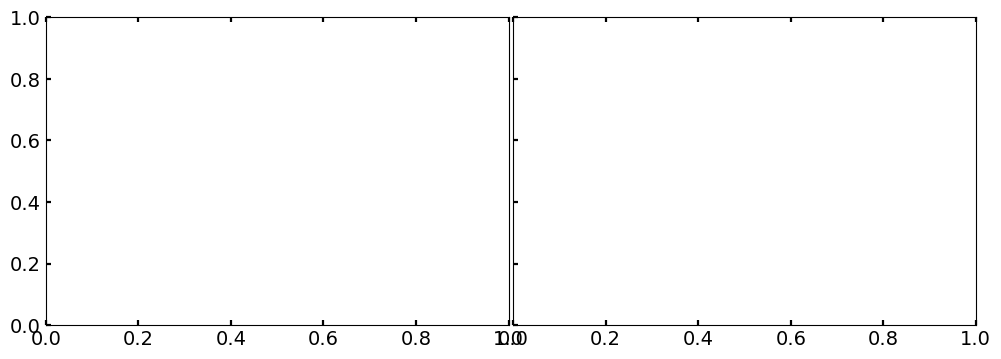

In [2]:
%%time
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from scipy.special import j0, jn_zeros, jv
import numpy as np

plt.rcParams.update({
    "figure.figsize": (12.0, 4),
    "text.usetex": False,
    "font.size": 14})

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def run_dynm_exact(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    H0 = Delta * sx
    H1 = sz
    
    H = [H0,[H1,drive]]

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times

def run_dynm_rwa(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    
    z = 2*h/w
    H = Delta * jv(0, z) * sx

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times


if __name__ == '__main__':
    
    freezing_pts = jn_zeros(0, 5)
    sx, sz = sigmax(), sigmaz()
    
    Delta = 1.0
    ws = [0.01, 20.0]
    nt = 100
    steps = 1000
    
    fig, axs = plt.subplots(1, 2, sharey=True, sharex=False)
    plt.subplots_adjust(wspace=0.01, hspace=0.0)
    
    for p, w in enumerate(ws): 
        print(r"Running for w = ", w)
        T = 2*np.pi/w
        h = w/2 * freezing_pts[0]  

        data_exact = np.array(run_dynm_exact(h,w,Delta, nt, steps))
        data_rwa = np.array(run_dynm_rwa(h,w,Delta, nt, steps))

        lbl11 = r"$H(t), \mathcal{{J}}_0(2h/\omega) =$"
        lbl12 = fr"${jv(0,h/w):1.2f}$"
        lbl1 = lbl11 + lbl12
        
        lbl21 = fr"$H_{{_{{RWA}}}}(t), \mathcal{{J}}_0(2h/\omega) =$"
        lbl22 = fr"${jv(0,h/w):1.2f}$"
        lbl2 = lbl21 + lbl22

        lbl = [lbl1,lbl2]

        times = data_exact[1]
        axs[p].plot(times/T,data_exact[0][0], label=lbl[0], linewidth =2, color = 'red')


        axs[p].set_xlabel(r"$T(n)$")
        axs[0].set_ylabel(r"$\langle \hat{\sigma}^z\rangle$")
        axs[p].tick_params(which='both', axis="x", direction="in", width= 1.0)
        axs[p].tick_params(which='both', axis="y", direction="in", width= 1.0)
        
        times = data_rwa[1]
        axs[p].plot(times/T,data_rwa[0][0], label=lbl[1], linewidth =2, linestyle ='dotted', color = 'blue')

        #plt.title(r'$S_x$ Dynamics_TSS: $\omega$=90 Spin =  $%4d$'%N)
        axs[p].set_xlabel(r"$T(n)$")
        #axs[1].set_ylabel(r"$\langle S_x\rangle$")
        axs[p].tick_params(which='both', axis="x", direction="in", width= 1.0)
        axs[p].tick_params(which='both', axis="y", direction="in", width= 1.0)
        
        axs[1].legend(loc = 4, frameon=False, fontsize =12)
        
        axs[p].set_title(fr"$\omega = {w:1.2f}$", fontsize = 13)
    #plt.ylim(0,1.1)
    
    figname = "rwa_vs_exact_w_low_n_high.pdf"
    plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
    
    plt.show()

/usr/local/anaconda3/anaconda3/envs/hpc/lib/python3.11/site-packages/qutip/configrc.py:294: UserWarning: Invalid qutip config variable in qutiprc: num_cpus
  warnings.warn("Invalid qutip config variable in qutiprc: "


Running for w =  0.05


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

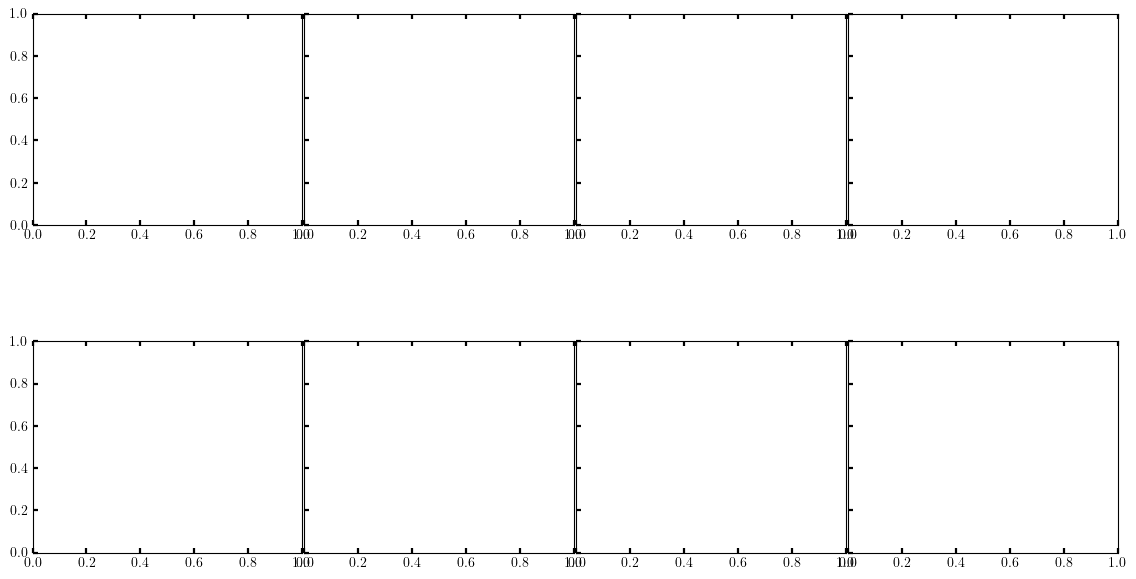

In [1]:
%%time
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from scipy.special import j0, jn_zeros, jv
import numpy as np

# Importing warnings
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"figure.figsize": (14, 7),"text.usetex": True,"font.size": 10})

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def run_dynm_exact(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    H0 = Delta * sx
    H1 = sz
    
    H = [H0,[H1,drive]]

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times

def run_dynm_rwa(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    
    z = 2 * h/w
    H = Delta * jv(0, z) * sx

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times


if __name__ == '__main__':
    
    freezing_pts = jn_zeros(0, 5)
    sx, sz = sigmax(), sigmaz()
    
    Delta = 1
    ws = [0.05, 5,10.0, 20.0]
    nt = 100
    steps = 1000
    
    frs = [freezing_pts[0], 3.5]
    
    fig, axs = plt.subplots(2, 4, sharey=True, sharex=False)
    plt.subplots_adjust(wspace=0.01, hspace=0.55)
    
    for q, fr in enumerate(frs):
        for p, w in enumerate(ws): 
            print(r"Running for w = ", w)
            T = 2*np.pi/w
            h = w/2 * fr    

            data_exact = np.array(run_dynm_exact(h,w,Delta, nt, steps))
            data_rwa = np.array(run_dynm_rwa(h,w,Delta, nt, steps))

            lbl11 = "Exact, " + r"$\mathcal{{J}}_0\Big(\frac{{2h}}{{\omega}}\Big) =$"
            lbl12 = fr"${jv(0,fr):1.2f}$"

            lbl1 = lbl11 + lbl12
            lbl21 = "RWA, " + fr"$\mathcal{{J}}_0\Big(\frac{{2h}}{{\omega}}\Big) =$"
            lbl22 = fr"${jv(0,fr):1.2f}$"
            lbl2 = lbl21 + lbl22

            lbl = [lbl1,lbl2]

            times = data_exact[1]
            axs[q][p].plot(times/T,data_exact[0][0], label=lbl[0], linewidth =2, color = 'red')
            
            axs[q][0].set_ylabel(r"$\langle \hat{\sigma}^z\rangle$", fontsize=14)
            axs[q][p].tick_params(which='both', axis="x", direction="in", width= 1.0)
            axs[q][p].tick_params(which='both', axis="y", direction="in", width= 1.0)

            times = data_rwa[1]
            axs[q][p].plot(times/T,data_rwa[0][0], label=lbl[1], linewidth =2, linestyle ='dotted', color = 'blue')

            #plt.title(r'$S_x$ Dynamics_TSS: $\omega$=90 Spin =  $%4d$'%N)
            axs[q][p].set_xlabel(r"$t/T$", fontsize=11)
            #axs[1].set_ylabel(r"$\langle S_x\rangle$")
            axs[q][p].tick_params(which='both', axis="x", direction="in", width= 1.0)
            axs[q][p].tick_params(which='both', axis="y", direction="in", width= 1.0)

            axs[q][1].legend(bbox_to_anchor=(0.15, 1.3), loc='upper left',\
                             frameon = True, fontsize = 10,ncol=2, fancybox=True,framealpha=True)
            axs[q][p].set_title(fr"$\omega = {w:1.2f}, h = {h:1.1f}$", fontsize = 9)
            
        #plt.ylim(0,1.1)
    #axs[0][0].text(0.0, 1.4, 'P', color='black', bbox=dict(facecolor='none', edgecolor='black'), fontsize=10)
    #axs[1][0].text(0.0, 1.4, 'Q', color='black', bbox=dict(facecolor='none', edgecolor='black'), fontsize=10)
    
    figname = "rwa_vs_exact_w_low_n_high_frz_nfrz.pdf"
    plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
    #plt.ylim(-1.1,1.1)
    plt.show()

Running for w =  0.05


Running for w =  5
Running for w =  10.0
Running for w =  20.0
Running for w =  0.05


Running for w =  5
Running for w =  10.0
Running for w =  20.0


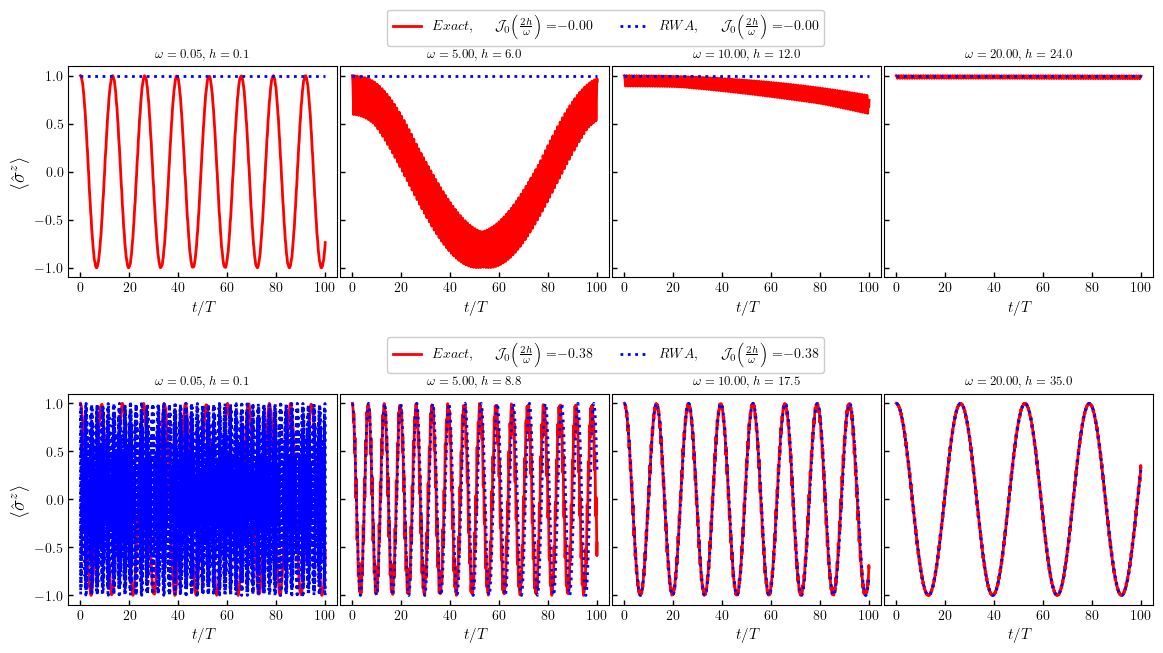

CPU times: user 10.3 s, sys: 223 ms, total: 10.5 s
Wall time: 10.7 s


In [1]:
%%time
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from scipy.special import j0, jn_zeros, jv
import numpy as np

# Importing warnings
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"figure.figsize": (14, 7),"text.usetex": True,"font.size": 10})

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def run_dynm_exact(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    H0 = Delta * sx
    H1 = sz
    
    H = [H0,[H1,drive]]

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times

def run_dynm_rwa(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    
    z = 2 * h/w
    H = Delta * jv(0, z) * sx

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times


if __name__ == '__main__':
    
    freezing_pts = jn_zeros(0, 5)
    sx, sz = sigmax(), sigmaz()
    
    Delta = 1
    ws = [0.05, 5,10.0, 20.0]
    nt = 100
    steps = 1000
    
    frs = [freezing_pts[0], 3.5]
    
    fig, axs = plt.subplots(2, 4, sharey=True, sharex=False)
    plt.subplots_adjust(wspace=0.01, hspace=0.55)
    
    for q, fr in enumerate(frs):
        for p, w in enumerate(ws): 
            print(r"Running for w = ", w)
            T = 2*np.pi/w
            h = w/2 * fr    

            data_exact = np.array(run_dynm_exact(h,w,Delta, nt, steps))
            data_rwa = np.array(run_dynm_rwa(h,w,Delta, nt, steps))

            lbl11 = r"$ Exact,\hskip 0.5cm \mathcal{{J}}_0\Big(\frac{{2h}}{{\omega}}\Big) =$"
            lbl12 = fr"${jv(0,fr):1.2f}$"

            lbl1 = lbl11 + lbl12
            lbl21 = fr"$RWA, \hskip 0.5cm \mathcal{{J}}_0\Big(\frac{{2h}}{{\omega}}\Big) =$"
            lbl22 = fr"${jv(0,fr):1.2f}$"
            lbl2 = lbl21 + lbl22

            lbl = [lbl1,lbl2]

            times = data_exact[1]
            axs[q][p].plot(times/T,data_exact[0][0], label=lbl[0], linewidth =2, color = 'red')
            
            axs[q][0].set_ylabel(r"$\langle \hat{\sigma}^z\rangle$", fontsize=14)
            axs[q][p].tick_params(which='both', axis="x", direction="in", width= 1.0)
            axs[q][p].tick_params(which='both', axis="y", direction="in", width= 1.0)

            times = data_rwa[1]
            axs[q][p].plot(times/T,data_rwa[0][0], label=lbl[1], linewidth =2, linestyle ='dotted', color = 'blue')

            #plt.title(r'$S_x$ Dynamics_TSS: $\omega$=90 Spin =  $%4d$'%N)
            axs[q][p].set_xlabel(r"$t/T$", fontsize=11)
            #axs[1].set_ylabel(r"$\langle S_x\rangle$")
            axs[q][p].tick_params(which='both', axis="x", direction="in", width= 1.0)
            axs[q][p].tick_params(which='both', axis="y", direction="in", width= 1.0)

            axs[q][1].legend(bbox_to_anchor=(0.15, 1.3), loc='upper left',\
                             frameon = True, fontsize = 10,ncol=2, fancybox=True,framealpha=True)
            axs[q][p].set_title(fr"$\omega = {w:1.2f}, h = {h:1.1f}$", fontsize = 9)
            
        #plt.ylim(0,1.1)
    #axs[0][0].text(0.0, 1.4, 'P', color='black', bbox=dict(facecolor='none', edgecolor='black'), fontsize=10)
    #axs[1][0].text(0.0, 1.4, 'Q', color='black', bbox=dict(facecolor='none', edgecolor='black'), fontsize=10)
    
    figname = "rwa_vs_exact_w_low_n_high_frz_nfrz.pdf"
    plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
    #plt.ylim(-1.1,1.1)
    plt.show()